In [ ]:
#! pip install imutils

Coding instructions courtesy of: 

Adrian Garrido

https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/

In [1]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten, Dropout
from keras import backend as K
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

Using TensorFlow backend.


## Model Construction - CNN
### Construct a VGGNet 

In [2]:
# Instantiate CNN model
class SmallVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
 
        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
            
        # CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
            
            
            
        # (CONV => RELU) * 2 => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
            
        
        # (CONV => RELU) * 3 => POOL layer set
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
 
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
 
        # return the constructed network architecture
        return model
        

### Gather and Pre-Process Images

In [3]:
# initialize the data and labels
data = []
labels = []
 
# grab the image paths and randomly shuffle them
church_path = sorted(list(paths.list_images('../train/church')))
mosque_path = sorted(list(paths.list_images('../train/mosque')))
temple_path = sorted(list(paths.list_images('../train/temple')))
combine_path = [church_path,mosque_path,temple_path]
random.seed(42)

# loop over the input data dictionaries
for path in combine_path:
    path = random.shuffle(path)

# loop over the input images
for imagePaths in combine_path:
    for imagePath in imagePaths:
        try:
            # load the image, resize the image to be 32x32 pixels (ignoring
            # aspect ratio), flatten the image into 32x32x3=3072 pixel image
            # into a list, and store the image in the data list
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (64, 64))
            data.append(image)

            # extract the class label from the image path and update the
            # labels list
            label = imagePath.split(os.path.sep)[-2].split('/')[-1]
            labels.append(label)
        except:
            pass

In [4]:
# Check Label to ensure proper processing
labels[780:790]

['church',
 'church',
 'mosque',
 'mosque',
 'mosque',
 'mosque',
 'mosque',
 'mosque',
 'mosque',
 'mosque']

In [5]:
# Check Label to ensure proper processing
labels[1879:1889]

['temple',
 'temple',
 'temple',
 'temple',
 'temple',
 'temple',
 'temple',
 'temple',
 'temple',
 'temple']

In [6]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [7]:
# Check labels for proper data type
labels

array(['church', 'church', 'church', ..., 'temple', 'temple', 'temple'],
      dtype='<U6')

### Run Model

In [8]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.25, random_state=42)
 
# convert the labels from integers to vectors (for 2-class, binary
# classification you should use Keras' to_categorical function
# instead as the scikit-learn's LabelBinarizer will not return a
# vector)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [9]:
trainY.shape

(1416, 3)

In [10]:
len(trainX)

1416

In [11]:
len(testX)

473

In [12]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")
 
# initialize our VGG-like Convolutional Neural Network
model = SmallVGGNet.build(width=64, height=64, depth=3,
    classes=len(lb.classes_))

W0827 13:40:04.832795 15948 deprecation_wrapper.py:119] From C:\Users\jly05\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 13:40:04.850319 15948 deprecation_wrapper.py:119] From C:\Users\jly05\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 13:40:04.855631 15948 deprecation_wrapper.py:119] From C:\Users\jly05\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 13:40:04.905046 15948 deprecation_wrapper.py:119] From C:\Users\jly05\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0827 13:40:04.909348 15948 deprecation_wrapper.py:119] 

In [13]:
# initialize our initial learning rate, # of epochs to train for,
# and batch size
INIT_LR = 0.01
EPOCHS = 20
BS = 32
 
# initialize the model and optimizer (you'll want to use
# categorical_crossentropy for 3-class classification)
print("[INFO] training network...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 
# train the network
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS)

W0827 13:40:14.061203 15948 deprecation_wrapper.py:119] From C:\Users\jly05\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



[INFO] training network...


W0827 13:40:14.374933 15948 deprecation.py:323] From C:\Users\jly05\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
44/44 [==============================] - 48s 1s/step - loss: 1.7728 - acc: 0.3935 - val_loss: 1.4241 - val_acc: 0.4461
Epoch 2/20
44/44 [==============================] - 42s 953ms/step - loss: 1.5381 - acc: 0.4326 - val_loss: 1.2195 - val_acc: 0.4736
Epoch 3/20
44/44 [==============================] - 42s 951ms/step - loss: 1.3419 - acc: 0.4312 - val_loss: 1.2317 - val_acc: 0.4588
Epoch 4/20
44/44 [==============================] - 41s 939ms/step - loss: 1.1718 - acc: 0.4880 - val_loss: 0.9967 - val_acc: 0.5159
Epoch 5/20
44/44 [==============================] - 42s 952ms/step - loss: 1.1793 - acc: 0.4730 - val_loss: 1.0640 - val_acc: 0.4884
Epoch 6/20
44/44 [==============================] - 42s 946ms/step - loss: 1.1342 - acc: 0.4851 - val_loss: 0.9673 - val_acc: 0.5285
Epoch 7/20
44/44 [==============================] - 41s 940ms/step - loss: 1.0813 - acc: 0.4886 - val_loss: 0.8910 - val_acc: 0.5497
Epoch 8/20
44/44 [==============================] - 41s 941ms/step - los

In [14]:
# Save the model
model.save('model_CNN_1')

### Evaluate Model

[INFO] evaluating network...
              precision    recall  f1-score   support

      church       0.56      0.60      0.58       200
      mosque       0.58      0.65      0.62       175
      temple       0.76      0.49      0.60        98

   micro avg       0.60      0.60      0.60       473
   macro avg       0.63      0.58      0.60       473
weighted avg       0.61      0.60      0.60       473

[INFO] serializing network and label binarizer...


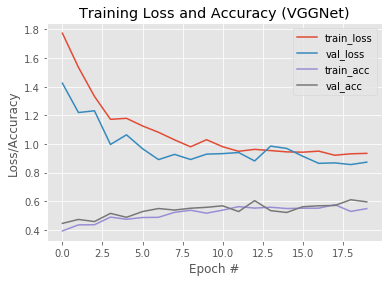

In [15]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))
 
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy (VGGNet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
#plt.savefig(args["plot"])
 
# save the model and label binarizer to disk
print("[INFO] serializing network and label binarizer...")
model.save('model_3B')
# f = open(args["label_bin"], "wb")
# f.write(pickle.dumps(lb))
# f.close()

In [16]:
H.history['val_acc'][-1]

0.5961945044313879

In [ ]:
# Show prediction results
predictions

In [17]:
# Set index to the largest number per row
# Set variable equal to the prediction results for future analysis
model_predictions = predictions.argmax(axis = 1)

In [18]:
# Set index to the largest number per row
# Set variable equal to the prediction results for future analysis
testY = testY.argmax(axis = 1)

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
confusion_matrix(testY, model_predictions)

array([[120,  69,  11],
       [ 57, 114,   4],
       [ 38,  12,  48]], dtype=int64)

## Actual vs Prediction Analysis

In [21]:
import pandas as pd

In [22]:
# Set array into dataframe for further analysis
df_predictions = pd.DataFrame(model_predictions)
df_predictions.columns = ['preds']
df_predictions.head()

,preds
0,1
1,1
2,0
3,2
4,0


In [23]:
# Set array into dataframe for further analysis
df_actuals = pd.DataFrame(testY)
df_actuals.columns = ['actuals']
df_actuals.head()

,actuals
0,1
1,1
2,2
3,2
4,1


In [24]:
# Create a dataframe that includes both actuals and prediction
actuals_pred_df = pd.concat([df_actuals, df_predictions], axis = 1, join= 'outer')

In [25]:
# Check dataframe 
actuals_pred_df.head()

,actuals,preds
0,1,1
1,1,1
2,2,0
3,2,2
4,1,0


In [26]:
# Create a function that will output a dataframe where the actuals and predictions did not match

def pred_errors(df, col1, col2):
    errors = []
    for i in range(len(df)):
        if df[col1][i] != df[col2][i]:
            errors.append(i)
    return df.loc[errors]

# running function on the previously created dataframe for actuals and predictions
    
pred_errors = pred_errors(actuals_pred_df, 'actuals', 'preds')

In [27]:
# Show total numbers of incorrect predictions
pred_errors.count()

actuals    191
preds      191
dtype: int64

In [28]:
# Desctibe the prediction errors
pred_errors.describe()

,actuals,preds
count,191.000000,191.000000
mean,0.842932,0.581152
std,0.812041,0.634500
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,1.000000
max,2.000000,2.000000


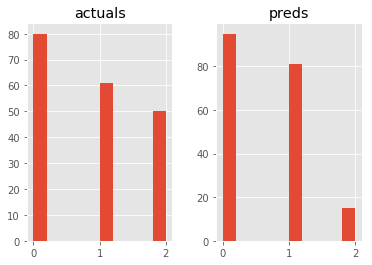

In [29]:
# Display a histogram of the prediction errors
pred_errors.hist();

## Make Predictions  - Out of Sample

In [30]:
from keras.models import load_model
from keras.preprocessing import image

In [31]:
# Create input images
image_1 = cv2.imread('../train/test/test (1).jpg')
image_2 = cv2.imread('../train/test/test (2).jpg')
image_3 = cv2.imread('../train/test/test (3).jpg')

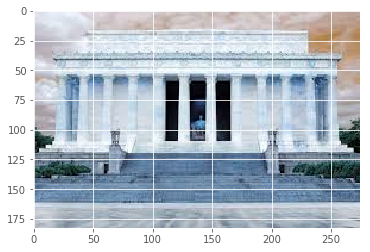

In [32]:
# Display image
plt.imshow(image_1);

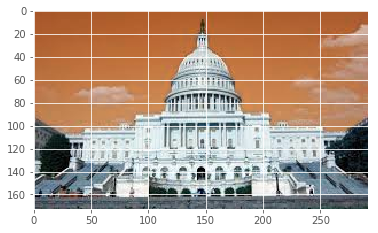

In [33]:
# Display image
plt.imshow(image_2);

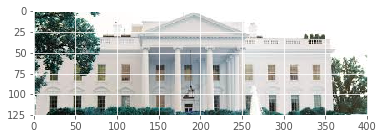

In [34]:
# Display image
plt.imshow(image_3);

In [35]:
# load the input images and resize it to the target spatial dimensions
#image = image.convert('RGB')
image_1 = cv2.resize(image_1, (64,64))
image_2 = cv2.resize(image_2, (64,64))
image_3 = cv2.resize(image_3, (64,64))
 
# scale the pixel values to [0, 1]
image_1 = image_1.astype("float") / 255.0
image_2 = image_2.astype("float") / 255.0
image_3 = image_3.astype("float") / 255.0

In [36]:
# Make predictions for out of sample testing images
image_pred_1 = np.expand_dims(image_1, axis = 0)
make_pred_1 = model.predict(image_pred_1)

image_pred_2 = np.expand_dims(image_2, axis = 0)
make_pred_2 = model.predict(image_pred_2)

image_pred_3 = np.expand_dims(image_3, axis = 0)
make_pred_3 = model.predict(image_pred_3)

In [37]:
make_pred_1

array([[0.4075678, 0.355187 , 0.2372452]], dtype=float32)

In [38]:
make_pred_2

array([[0.47971532, 0.43767944, 0.08260521]], dtype=float32)

In [39]:
make_pred_3

array([[0.68221235, 0.28915796, 0.02862969]], dtype=float32)

## LIVE DEMO

In [40]:
# Create input images
image_1 = cv2.imread('../train/test/Westminster_Abbey.jpg')
image_2 = cv2.imread('../train/test/sensoji_temple.jpg')
image_3 = cv2.imread('../train/test/Big_Buddha.jpg')

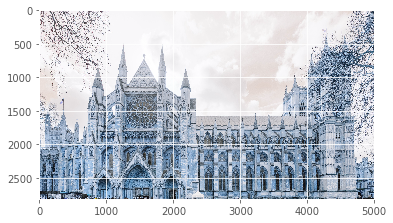

In [41]:
# Display image
plt.imshow(image_1);

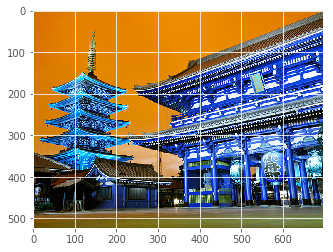

In [42]:
# Display image
plt.imshow(image_2);

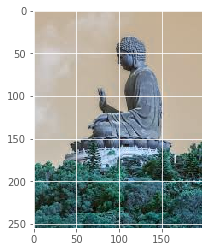

In [43]:
# Display image
plt.imshow(image_3);

In [44]:
# load the input images and resize it to the target spatial dimensions
#image = image.convert('RGB')
image_1 = cv2.resize(image_1, (64,64))
image_2 = cv2.resize(image_2, (64,64))
image_3 = cv2.resize(image_3, (64,64))
 
# scale the pixel values to [0, 1]
image_1 = image_1.astype("float") / 255.0
image_2 = image_2.astype("float") / 255.0
image_3 = image_3.astype("float") / 255.0

In [45]:
# Make predictions for out of sample testing images
image_pred_1 = np.expand_dims(image_1, axis = 0)
make_pred_1 = model.predict(image_pred_1)

image_pred_2 = np.expand_dims(image_2, axis = 0)
make_pred_2 = model.predict(image_pred_2)

image_pred_3 = np.expand_dims(image_3, axis = 0)
make_pred_3 = model.predict(image_pred_3)

In [46]:
# Display prediction
make_pred_1

array([[0.34221026, 0.41978765, 0.23800212]], dtype=float32)

In [47]:
# Display prediction
make_pred_2

array([[0.13827573, 0.26470125, 0.59702307]], dtype=float32)

In [48]:
# Display prediction
make_pred_3

array([[0.20640607, 0.60537064, 0.18822326]], dtype=float32)